In [2]:
from math import pi 
import torch

def make_sine_wave(pitch, amplitude, duration, sampling_rate):
  return torch.sin(torch.arange(sampling_rate*duration)/sampling_rate * pitch * 2 * pi) * amplitude

pitch_list = list(range(400, 1500, 100))
pitch_list

[400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]

In [23]:
import random 
import IPython.display as ipd
duration = 2 
SR = 16000
total_data = []

for pitch in pitch_list: 
  pitch_wave = []
  for i in range(100):
    amplitude = random.random() **3
    sine_wave = make_sine_wave(pitch, amplitude, duration, SR)
    white_noise = torch.rand(SR * duration) * 2 -1 # 0부터 1사이의 값이 32000개
    sine_wave += white_noise * random.random() **2
    pitch_wave.append(sine_wave)
  pitch_wave = torch.stack(pitch_wave)

  total_data.append(pitch_wave)

In [26]:
total_tensor = torch.stack(total_data)
total_tensor.shape #pitch name, pitch * 100, 32000개의 샘플 dur * sample_rate

torch.Size([11, 100, 32000])

In [32]:
import torchaudio
#pitch를 맞추는 문제를 하고싶음
#n_fft는 큰게 좋음, 적당히 넓은게 중요함

spec_converter = torchaudio.transforms.Spectrogram(n_fft = 1024, hop_length =512)
total_spec = spec_converter(total_tensor)

In [33]:
total_spec.shape # 11ㄱ개의 피치, 100개의 오디오 샘플, 프리퀀시 513, time축은 63개

torch.Size([11, 100, 513, 63])

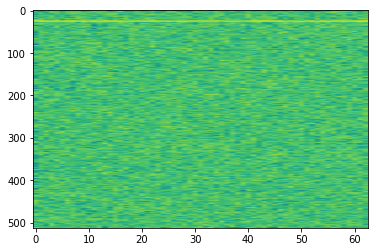

In [55]:
import matplotlib.pyplot as plt
plt.imshow(torch.log(total_spec[0][0][:]), aspect ='auto')


In [34]:
#4번째 pitch에, 17번째 오디오 사인 샘플
total_spec[4,17]

tensor([[9.1212e+00, 3.2450e+00, 6.2398e+00,  ..., 5.1727e-02, 1.2830e-01,
         1.9825e+01],
        [3.0660e-02, 3.6041e-01, 1.0743e+00,  ..., 1.0286e+01, 4.4980e+00,
         4.3468e+00],
        [7.7743e+00, 8.0550e+00, 3.4006e+00,  ..., 2.0218e+01, 5.6037e+00,
         1.0162e+01],
        ...,
        [1.1393e+00, 1.7905e+00, 3.2845e+01,  ..., 1.5299e+00, 1.7457e+00,
         2.1243e+01],
        [1.2275e+01, 6.3523e+00, 3.7157e+01,  ..., 2.4386e+01, 4.9498e+00,
         1.9276e+01],
        [5.4236e+00, 3.0267e+00, 2.9085e+01,  ..., 7.3760e+00, 3.6817e+00,
         8.4943e+00]])

In [69]:
# 513개를 받아서 Pitch가 무슨 피치인지 맞추기
model = torch.randn(513, 11, requires_grad = True) / 513
model

tensor([[-0.0010, -0.0009, -0.0021,  ...,  0.0003,  0.0008,  0.0020],
        [-0.0001, -0.0006,  0.0020,  ..., -0.0039, -0.0002,  0.0001],
        [-0.0025,  0.0024,  0.0008,  ...,  0.0015,  0.0022, -0.0018],
        ...,
        [-0.0008,  0.0019,  0.0009,  ..., -0.0023, -0.0003,  0.0015],
        [ 0.0019, -0.0011, -0.0019,  ...,  0.0030, -0.0011, -0.0005],
        [ 0.0030,  0.0003,  0.0012,  ..., -0.0018, -0.0014, -0.0009]],
       grad_fn=<DivBackward0>)

In [70]:
model[0, 5] #0번째 frequency bin에 대한 5번째 뉴런의 weight -> 5번째 피치의

tensor(-0.0037, grad_fn=<SelectBackward0>)

In [71]:
pitch_list

[400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]

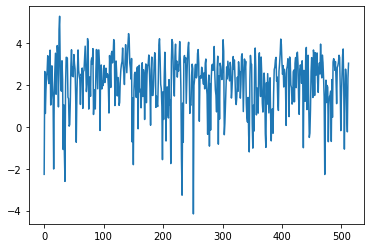

In [72]:
log_spec = torch.log(total_spec + 1e-6)

#0번째 pitch의 5번째 sine sample의 전체 frequency bin, 30번째 time bin
input_tensor = log_spec[0,5,:,30]
input_tensor.shape
plt.plot(input_tensor)

In [75]:
output = torch.matmul(input_tensor, model) # [1,513] * [513,11]


In [76]:
torch.softmax(output, dim = 0)

tensor([0.0883, 0.0854, 0.0992, 0.1007, 0.0813, 0.1053, 0.0770, 0.0945, 0.0931,
        0.0889, 0.0863], grad_fn=<SoftmaxBackward0>)

In [77]:
# softmax 직접 구현하기
def softmax(output, dim = 0):
  expotential_value = torch.exp(output) #분자
  expotentail_value_sum = expotential_value.sum() 
  return expotential_value/expotentail_value_sum

softmax(output)


tensor([0.0883, 0.0854, 0.0992, 0.1007, 0.0813, 0.1053, 0.0770, 0.0945, 0.0931,
        0.0889, 0.0863], grad_fn=<DivBackward0>)

In [78]:
softmax_result = torch.softmax(output, dim = 0)
softmax_result
#우리는 0번째 pitch임을 맞춰야함으로, 0번째의 값을(확률)을 높여줘야 한다고 할 수 있음.
#즉 1에 가까워져야 한단 것

tensor([0.0883, 0.0854, 0.0992, 0.1007, 0.0813, 0.1053, 0.0770, 0.0945, 0.0931,
        0.0889, 0.0863], grad_fn=<SoftmaxBackward0>)

In [79]:
target_class_prob = softmax_result[0]
target_class_prob #이 값이 최대한 1에 가까워쟈야 한다.


tensor(0.0883, grad_fn=<SelectBackward0>)

# Negative log-likelihood (NLL)
- 확률을 예측할 때 사용하기 좋은 loss 함수
- 1(정답)이면 손실값은 0
- 0에 가까워질수록 무한에 가깝게 커짐
- 기본적으로 softmax값을 사용한다

In [82]:
loss = -torch.log(target_class_prob + 1e-6)
loss

tensor(2.4267, grad_fn=<NegBackward0>)

In [ ]:
loss.backward()

In [87]:
model.grad

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


AttributeError: ignored

In [96]:
#위 모델을 재정의 (오류가 나서)
import torch.nn as nn
model = nn.Linear(513,11)

def run_model(model, input_tensor, label_idx):
  output = torch.matmul(input_tensor, model.weight.T)
  softmax_result = torch.softmax(output, dim = 0)
  loss = -torch.log(softmax_result[label_idx] + 1e-6)
  return loss

def update_parameters(model, lr = 0.001):
  model.weight.data -= model.weight.grad * lr # update model parameter
  model.weight.grad = None 


In [97]:

loss = run_model(model, input_tensor, 0 )
print(loss)
loss.backward()
update_parameters(model)
loss = run_model(model, input_tensor, 0 )
print(loss)


tensor(4.6583, grad_fn=<NegBackward0>)
tensor(1.0849, grad_fn=<NegBackward0>)


In [98]:
torch.set_printoptions(sci_mode=False)
torch.softmax(model(input_tensor), dim = 0)
#0번값이 가장 좋아진 것을 확인할 수 있음.

tensor([0.3381, 0.1289, 0.0020, 0.0022, 0.1430, 0.1038, 0.0623, 0.0435, 0.0284,
        0.1364, 0.0113], grad_fn=<SoftmaxBackward0>)

In [93]:
model.weight.grad # grad가 음수면 

tensor([[ 1.9626e+00, -2.2996e+00, -5.5864e-01,  ...,  2.0153e-01,
         -2.0068e+00, -2.6413e+00],
        [-2.5856e-01,  3.0297e-01,  7.3599e-02,  ..., -2.6551e-02,
          2.6438e-01,  3.4798e-01],
        [-2.3765e-02,  2.7846e-02,  6.7646e-03,  ..., -2.4404e-03,
          2.4300e-02,  3.1984e-02],
        ...,
        [-1.5916e-01,  1.8650e-01,  4.5305e-02,  ..., -1.6344e-02,
          1.6275e-01,  2.1421e-01],
        [-4.8380e-01,  5.6690e-01,  1.3771e-01,  ..., -4.9681e-02,
          4.9470e-01,  6.5113e-01],
        [-5.4114e-01,  6.3408e-01,  1.5404e-01,  ..., -5.5569e-02,
          5.5333e-01,  7.2830e-01]])

In [100]:
def get_input_tensor(pitch):
  sample_idx = random.randint(0,99)
  input_tensor = log_spec[pitch, sample_idx, : , 30]
  return input_tensor

pitch_id = 5
input_tensor = get_input_tensor(pitch_id)
run_model(model, input_tensor, pitch_id)

tensor(3.4240, grad_fn=<NegBackward0>)

In [107]:
loss_record = []
model = nn.Linear(513, 11)

for i in range(5000):
  for pitch in range(11):
    input_tensor = get_input_tensor(pitch)
    loss = run_model(model, input_tensor, pitch)
    loss.backward()
    update_parameters(model, lr=1e-4)
    loss_record.append(loss.item())

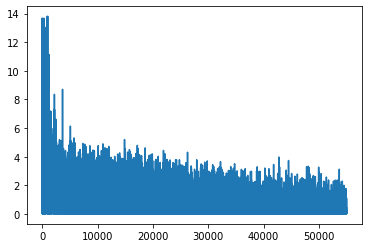

In [119]:
plt.plot(loss_record)

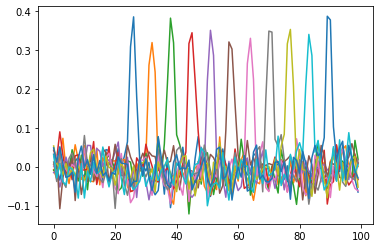

In [123]:
# Weight VISUALIZATION
for i in range(11):
  plt.plot(model.weight[i,:100].detach())

#weight 가중치를 조정함으로써, 각 pitch를 맞추는 가중치 값이 높아짐을 확인할 수 있다.

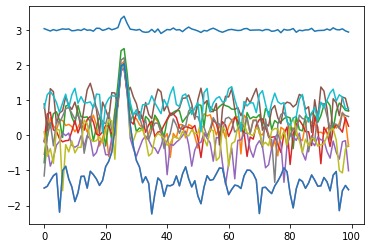

In [128]:
pitch_id = 0
plt.plot(model.weight[pitch_id, :100].detach() + 3)
for _ in range(10):
  plt.plot(get_input_tensor(pitch_id)[:100]/4)

In [125]:
torch.log(torch.zeros(1) + 1e-7)
# Vanishing Gradient Descent 방지

tensor([-inf])

# nn.Linear의 역할은 무엇인가!

In [122]:

'''
nn.Linear의 역할을 정리하면 [12,5]의 레이어가 나온다.
이 레이어에는 12 * 5의 weight와 5개의 bias가 있다는 뜻이다.
nn.Linear(sample)를 넣어주면 torch.matmul(sample, sample_linear.weight.T) + sample_linear.bias 의 역할을 한다.
다시말해서, nn.Linear(?)을 넣어주면 [12,5] * [1, 12]를 해주는 것이다.
여기서 weight.T를 넣는 이유는 weight의 shape는 [5,12]이기 때문에 이를 [12,5]의 모양으로 변환하기 위함
(행렬곱을 위함)
'''

sample_linear = nn.Linear(12, 5)
#print(sample_linear.weight, sample_linear.bias) 

sample_input = torch.arange(12).float()
output_a = sample_linear(sample_input)
output_b = torch.matmul(sample_input, sample_linear.weight.T) + sample_linear.bias
output_a, output_b, sample_linear.bias
sample_linear.weight.shape, output_a.shape

(torch.Size([5, 12]), torch.Size([5]))

In [113]:
sample_linear.weight.T.shape

torch.Size([12, 5])